Import Necessary Libraries

1)pandas :- Import/Exporting Data, Manipulating Data, Other Data Analysis Task
2) Numpy :-	Working with Numerical Value
3) Matplotlib and Seaborn :-	Creating Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load your data

In [2]:
df = pd.read_csv('/home/kashika/Customer_Seg_Prjct/Cstmr_Dataset.csv')
df.head()

,CustomerKey,FirstName,LastName,BirthDate,MaritalStatus,Gender,EmailAddress,YearlyIncome,TotalChildren,NumberChildrenAtHome,...,StateProvinceName,Country,PostalCode,ProductName,ProductSubcategoryName,ProductCategoryName,TotalOrders,TotalSalesAmount,LastOrderDate,FirstOrderDate
0,11000,Jon,Yang,06-10-1971,M,M,jon24@adventure-works.com,90000,2,0,...,Queensland,Australia,4700,Fender Set - Mountain,Fenders,Accessories,1,21.98,2013-01-18 0:00,2013-01-18 0:00
1,11000,Jon,Yang,06-10-1971,M,M,jon24@adventure-works.com,90000,2,0,...,Queensland,Australia,4700,"Mountain-100 Silver, 38",Mountain Bikes,Bikes,1,3399.99,2011-01-19 0:00,2011-01-19 0:00
2,11000,Jon,Yang,06-10-1971,M,M,jon24@adventure-works.com,90000,2,0,...,Queensland,Australia,4700,"Mountain-200 Silver, 38",Mountain Bikes,Bikes,1,2319.99,2013-01-18 0:00,2013-01-18 0:00
3,11000,Jon,Yang,06-10-1971,M,M,jon24@adventure-works.com,90000,2,0,...,Queensland,Australia,4700,"Short-Sleeve Classic Jersey, S",Jerseys,Clothing,1,53.99,2013-05-03 0:00,2013-05-03 0:00
4,11000,Jon,Yang,06-10-1971,M,M,jon24@adventure-works.com,90000,2,0,...,Queensland,Australia,4700,"Sport-100 Helmet, Red",Helmets,Accessories,1,34.99,2013-05-03 0:00,2013-05-03 0:00


Check for null values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58922 entries, 0 to 58921
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerKey             58922 non-null  int64  
 1   FirstName               58922 non-null  object 
 2   LastName                58922 non-null  object 
 3   BirthDate               58922 non-null  object 
 4   MaritalStatus           58922 non-null  object 
 5   Gender                  58922 non-null  object 
 6   EmailAddress            58922 non-null  object 
 7   YearlyIncome            58922 non-null  int64  
 8   TotalChildren           58922 non-null  int64  
 9   NumberChildrenAtHome    58922 non-null  int64  
 10  Education               58922 non-null  object 
 11  Occupation              58922 non-null  object 
 12  HouseOwnerFlag          58922 non-null  int64  
 13  NumberCarsOwned         58922 non-null  int64  
 14  CommuteDistance         58922 non-null

In [4]:
# Convert date columns to datetime
df['LastOrderDate'] = pd.to_datetime(df['LastOrderDate'], errors='coerce')
df['FirstOrderDate'] = pd.to_datetime(df['FirstOrderDate'], errors='coerce')

In [5]:
# Drop irrelevant columns for RFM (keep CustomerKey, LastOrderDate, TotalOrders, TotalSalesAmount)
rfm_df = df[['CustomerKey', 'LastOrderDate', 'TotalOrders', 'TotalSalesAmount']].copy()

In [6]:
# Set reference date as one day after the most recent purchase
reference_date = rfm_df['LastOrderDate'].max() + pd.Timedelta(days=1)

# Group by CustomerKey in case there are multiple records per customer
rfm = rfm_df.groupby('CustomerKey').agg({
    'LastOrderDate': lambda x: (reference_date - x.max()).days,  # Recency
    'TotalOrders': 'sum',                                        # Frequency
    'TotalSalesAmount': 'sum'                                    # Monetary
}).reset_index()

rfm.rename(columns={
    'LastOrderDate': 'Recency',
    'TotalOrders': 'Frequency',
    'TotalSalesAmount': 'Monetary'
}, inplace=True)


# Assign RFM Scores


In [7]:
# Recency: lower is better, so reverse the labels
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# Combine scores
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']
rfm.head()


,CustomerKey,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,11000,271,8,8248.99,2,5,5,12
1,11001,50,11,6383.88,5,5,5,15
2,11002,340,4,8114.04,1,4,5,10
3,11003,264,9,8139.29,2,5,5,12
4,11004,273,6,8196.01,2,5,5,12


# Segment Customers based on RFM Score


In [8]:
def rfm_segment(row):
    # Define threshold for "Recent Customers" (e.g., Recency <= 30 days)
    if row['Recency'] <= 30:
        return 'Recent Customer'
    elif row['RFM_Score'] >= 13:
        return 'Champions'
    elif row['RFM_Score'] >= 10:
        return 'Loyal'
    elif row['RFM_Score'] >= 7:
        return 'Potential'
    else:
        return 'At Risk'

rfm['RFM_Segment'] = rfm.apply(rfm_segment, axis=1)

In [9]:
rfm['RFM_Segment'].head()

0        Loyal
1    Champions
2        Loyal
3        Loyal
4        Loyal
Name: RFM_Segment, dtype: object

# Visualization

In [10]:
# Segment profile
print(rfm['RFM_Segment'].value_counts())
print(rfm.groupby('RFM_Segment')[['Recency', 'Frequency', 'Monetary']].mean())

RFM_Segment
Potential          5807
Loyal              5396
At Risk            4123
Champions          2260
Recent Customer     898
Name: count, dtype: int64
                    Recency  Frequency     Monetary
RFM_Segment                                        
At Risk          273.169294   1.709435   217.898537
Champions         88.550442   5.645575  4481.790718
Loyal            155.274092   3.972572  2323.520085
Potential        230.770277   2.530394   980.371500
Recent Customer   15.325167   4.967706   112.141258


Bar Chart

/tmp/ipykernel_7358/2598667087.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


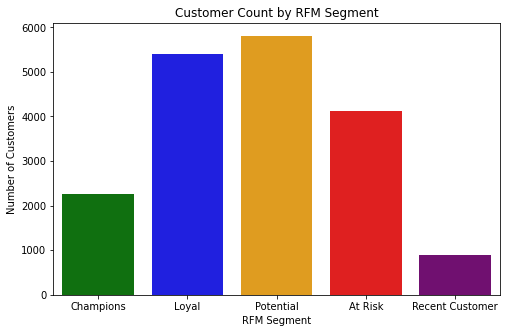

In [11]:
# Define consistent colors for each RFM segment
segment_colors = {
    'Champions': 'green',
    'Loyal': 'blue',
    'Potential': 'orange',
    'At Risk': 'red',
    'Recent Customer' : 'purple'
}

# Bar plot with consistent colors
plt.figure(figsize=(8,5))
sns.countplot(
    data=rfm, 
    x='RFM_Segment', 
    order=['Champions', 'Loyal', 'Potential', 'At Risk', 'Recent Customer'],
    palette=segment_colors
)
plt.title('Customer Count by RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.show()

# Pie chart of customer distribution by RFM Segment

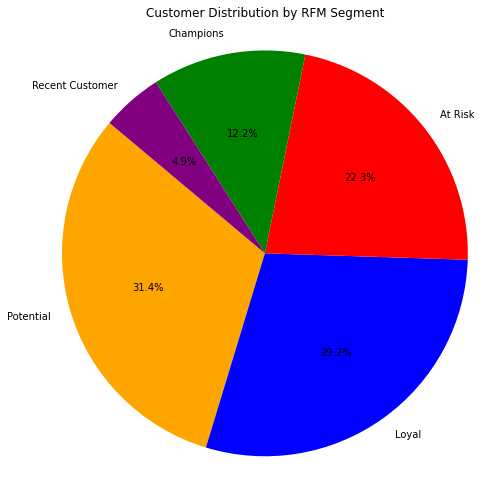

In [12]:
# Pie chart with consistent colors
plt.figure(figsize=(8, 8))
segment_counts = rfm['RFM_Segment'].value_counts()
colors = [segment_colors[segment] for segment in segment_counts.index]
plt.pie(
    segment_counts,
    labels=segment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title('Customer Distribution by RFM Segment',y=1.03)
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

Export dataframe for further analysis

In [13]:
rfm.to_csv("rfm_customer_segmented.csv", index = False)

# Conclusion

1) R stands for recency (how many days since the last purchase?)
   F stands for frequency (how many times the transaction occurs)
   M stands for Monetary(how much money spend?)

2) Source :- AdventureworksDatabase

3) Upon completing this segmentation, it is clear that RFM analysis is a powerful method for businesses to better understand their customer base. By evaluating customers based on how recently they made a purchase (Recency), how often they buy (Frequency), and how much they spend (Monetary), RFM segmentation enables organizations to categorize customers into meaningful groups. Each segment reveals unique behaviors and preferences, allowing companies to tailor their marketing strategies and services more effectively to meet the specific needs of different customer groups.

 => Since the "Potential" segment makes up the largest proportion of customers (31.4%), this indicates a significant group with the capacity to become more valuable. By engaging and nurturing these customers with targeted offers and personalized communication, the business can potentially convert them into loyal or high-value clients.
 
 => With 29.2% of customers classified as "Loyal," the business has a strong base of repeat buyers who consistently engage with its products or services. This substantial segment presents an excellent opportunity for upselling, cross-selling, and fostering long-term relationships to maximize customer lifetime value.

 => Since the "At Risk" segment constitutes the third highest proportion at 22.3%, it indicates that a significant portion of customers are at risk of becoming inactive or churning. This highlights the need for targeted retention strategies—such as re-engagement campaigns or personalized offers—to win back and retain these valuable customers before they are lost.